In [2]:
pip install imutils

  Using cached imutils-0.5.4.tar.gz (17 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25854 sha256=718b03c5f6c73dbb1c5b7fb6770b66be5247a0088b362265169c3c779566c5f2
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\c2\02\32\f3617a9f68bcc67eda3ebeb4514eba18f62e81ff439428109d
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [ ]:
tensorflow>=1.15.2
keras==2.3.1
imutils==0.5.3
numpy==1.18.2
opencv-python==4.2.0.*
matplotlib==3.2.1
scipy==1.4.1

In [6]:
pip install opencv-python

  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [8]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [9]:
DIRECTORY = r"C:\Users\user\Downloads\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [10]:
print("[INFO] loading images...")

[INFO] loading images...


In [11]:
data = []
labels = []


In [12]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)
        

C:\Program Files\anaconda\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [13]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [14]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

In [15]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [16]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [17]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [18]:
for layer in baseModel.layers:
    layer.trainable = False
    
    

In [19]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr = INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])


[INFO] compiling model...


C:\Program Files\anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 146s 2s/step - loss: 0.0889 - accuracy: 0.9763 - val_loss: 0.0476 - val_accuracy: 0.9935
Epoch 2/20
95/95 [==============================] - 147s 2s/step - loss: 0.0776 - accuracy: 0.9792 - val_loss: 0.0425 - val_accuracy: 0.9935
Epoch 3/20
95/95 [==============================] - 147s 2s/step - loss: 0.0597 - accuracy: 0.9845 - val_loss: 0.0379 - val_accuracy: 0.9935
Epoch 4/20
95/95 [==============================] - 159s 2s/step - loss: 0.0614 - accuracy: 0.9799 - val_loss: 0.0350 - val_accuracy: 0.9922
Epoch 5/20
95/95 [==============================] - 152s 2s/step - loss: 0.0493 - accuracy: 0.9848 - val_loss: 0.0335 - val_accuracy: 0.9935
Epoch 6/20
95/95 [==============================] - 151s 2s/step - loss: 0.0525 - accuracy: 0.9838 - val_loss: 0.0303 - val_accuracy: 0.9935
Epoch 7/20
95/95 [==============================] - 146s 2s/step - loss: 0.0496 - accuracy: 0.9862 - val_loss: 0.0298 - val_accura

[INFO] evaluating network...
24/24 [==============================] - 24s 920ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[INFO] saving mask detector model...


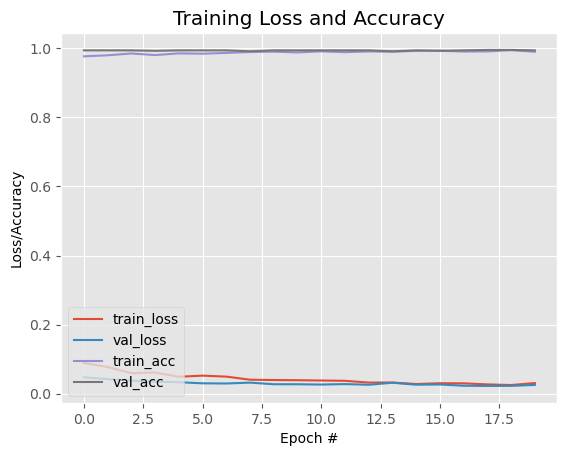

In [22]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")

plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")